In [113]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib as mpl
import matplotlib.pyplot as plt   # data visualization

import numpy as np             #for numerical computations like log,exp,sqrt etc
import pandas as pd            #for reading & storing data, pre-processing
import matplotlib.pylab as plt #for visualization
            
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from matplotlib.pylab import rcParams

We read the zinc prices from the excel file and rename the columns in the dataframe as below.

In [114]:
rcParams['figure.figsize'] = 10, 6

file = 'zinc.csv.xlsx'

# Reading the data from excel and plotting a zinc price-time graph

df = pd.read_excel(file)
df.dropna(inplace=True)
df.shape
df.rename(columns={'date': 'Date', 'LME_Zinc_Cash_Settlement': 'Zinc'}, inplace=True)

We plot the zinc prices over time. 

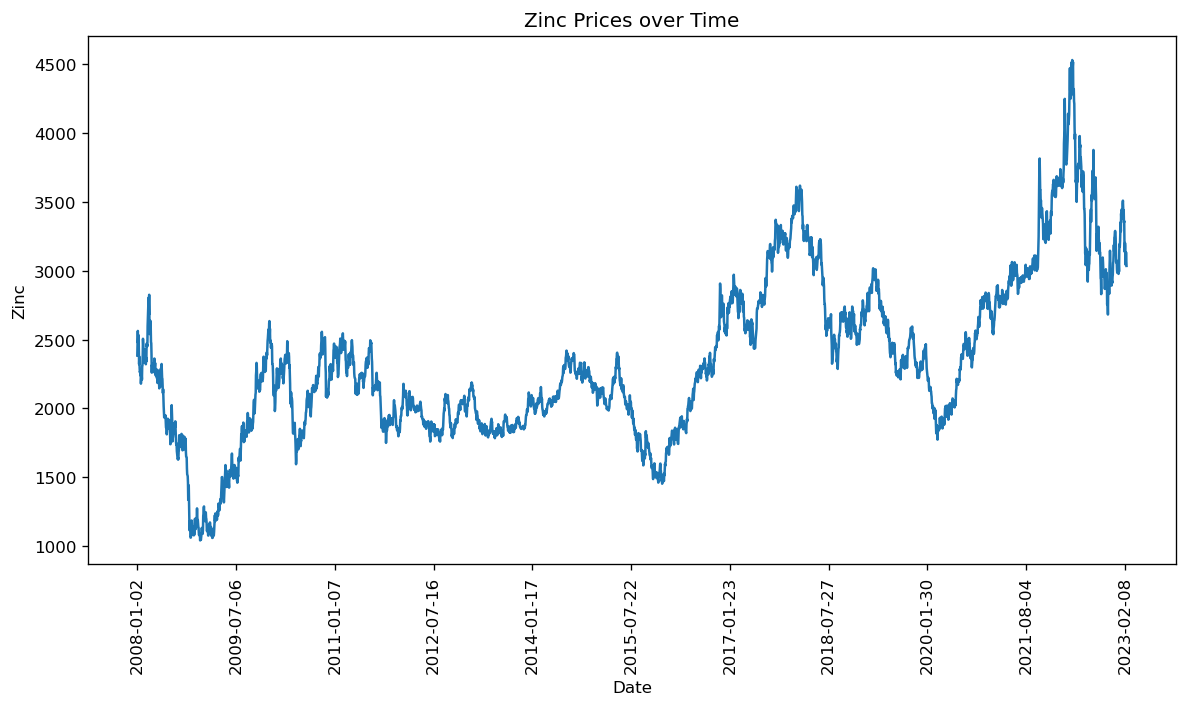

In [115]:
x = df['Date'].astype(str)
y = pd.to_numeric(df['Zinc'], errors='coerce')
plt.plot(x, y)

plt.xticks(rotation=90)  
num_ticks = 10  
step = len(x) // num_ticks  
plt.xticks(range(0, len(x), step), x[::step])

plt.xlabel('Date')
plt.ylabel('Zinc')
plt.title('Zinc Prices over Time')

plt.tight_layout()

plt.show()

In [116]:
df.head()

,Date,Zinc
0,2008-01-02,2384.0
1,2008-01-03,2466.0
2,2008-01-04,2563.0
3,2008-01-07,2475.5
4,2008-01-08,2534.0


In [117]:
df.tail()

,Date,Zinc
3822,2023-02-10,3119.0
3823,2023-02-13,3042.0
3824,2023-02-14,3134.0
3825,2023-02-15,3067.0
3826,2023-02-16,3035.0


We define a function which tests for stationarity of the time series by calculating its mean and standard deviation, and conducting an Augmented Dickey-Fuller Test.

In [118]:
# Test for stationarity

from statsmodels.tsa.stattools import adfuller

def stationarity(timeseries: pd.DataFrame, column):
    
    rolmean=timeseries.rolling(365).mean()
    rolstd=timeseries.rolling(365).std()
    
    plt.figure(figsize=(20,10))
    actual=plt.plot(timeseries[column], color='red', label='Actual')
    mean_6=plt.plot(rolmean, color='green', label='Rolling Mean') 
    std_6=plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    print('Dickey-Fuller Test: ')
    dftest=adfuller(timeseries[column], autolag='AIC')
    dfoutput=pd.Series(dftest[0:4], index=['Test Statistic','p-value','Lags Used','No. of Obs'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

C:\Users\bilge\AppData\Local\Temp\ipykernel_7544\3932990620.py:7: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['Date'], dtype='object')
  rolmean=timeseries.rolling(365).mean()
C:\Users\bilge\AppData\Local\Temp\ipykernel_7544\3932990620.py:8: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['Date'], dtype='object')
  rolstd=timeseries.rolling(365).std()


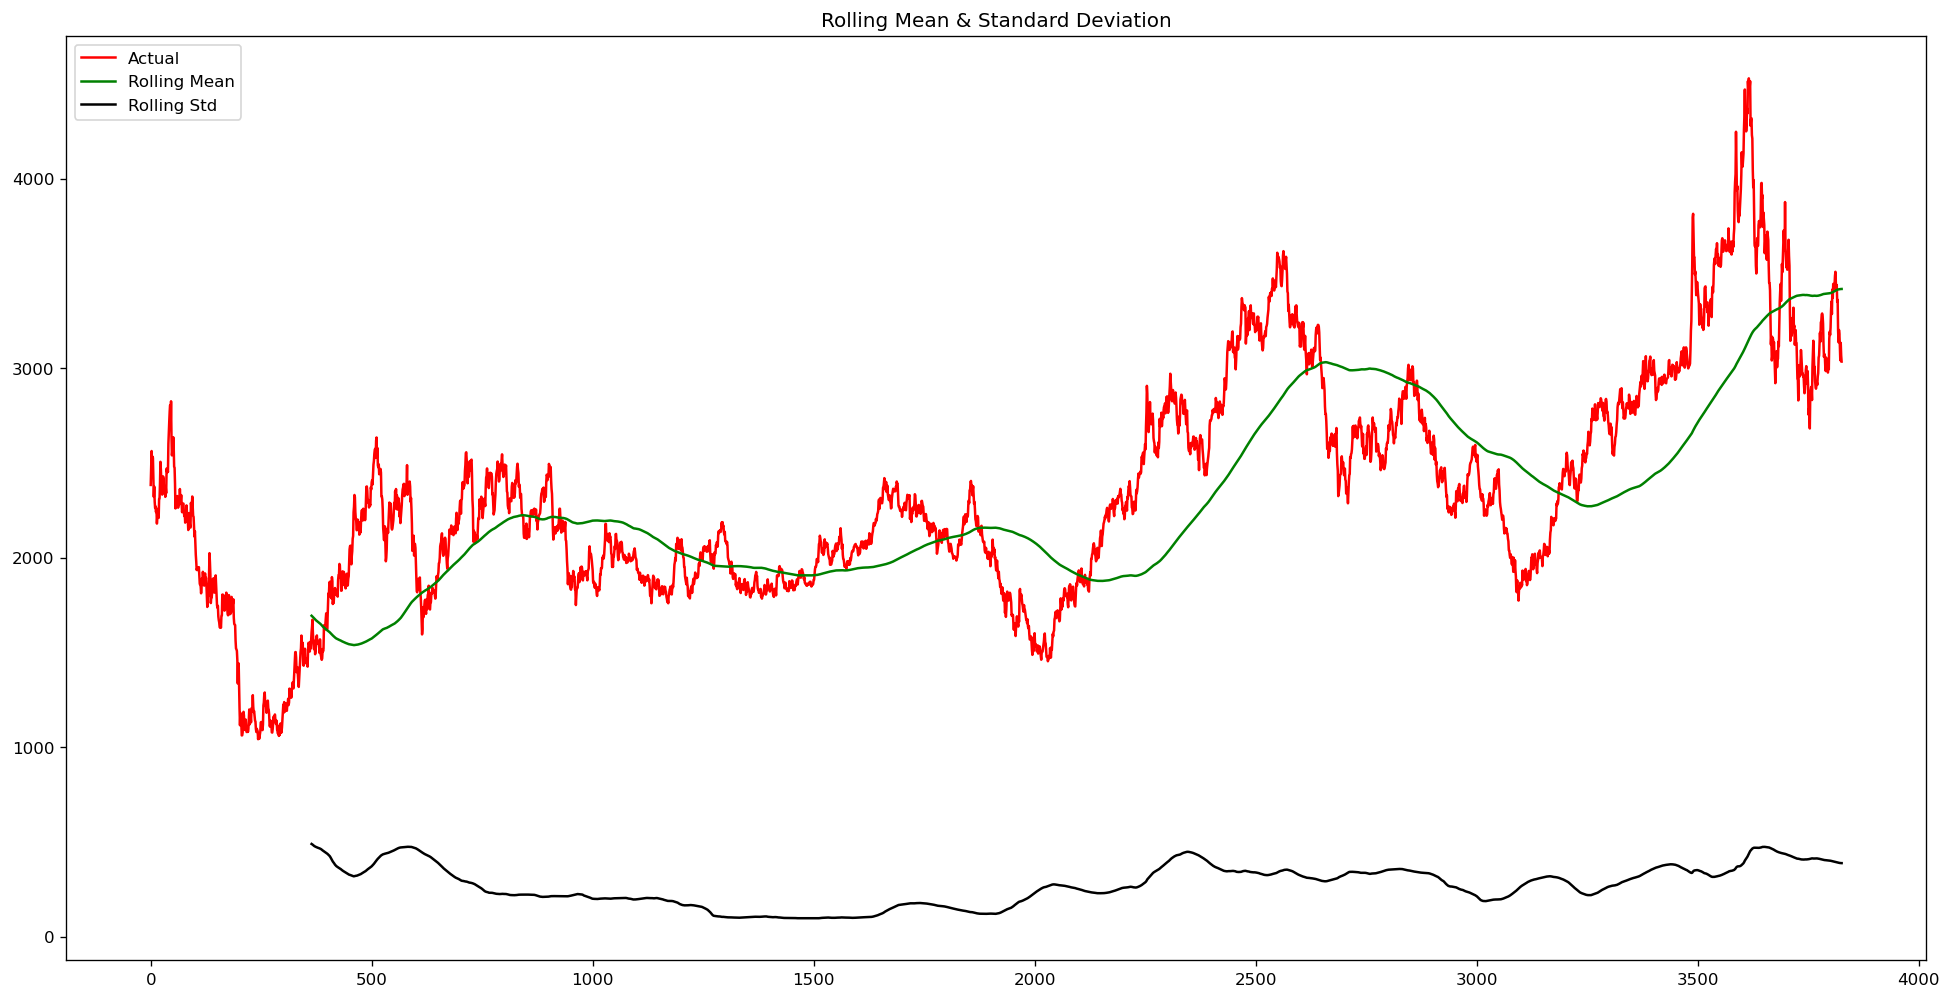

Dickey-Fuller Test: 
Test Statistic            -2.180139
p-value                    0.213533
Lags Used                  2.000000
No. of Obs              3824.000000
Critical Value (1%)       -3.432061
Critical Value (5%)       -2.862296
Critical Value (10%)      -2.567172
dtype: float64


In [119]:
stationarity(df, 'Zinc')

The original time series is tested for stationarity. When the rolling mean and standard deviation is plotted against the actual values, it is observed that both the rolling mean and standard deviation fluctuates over time. Looking at the results of the Augmented Dickey-Fuller test, we observe that the p-value is 0.213533, which is much higher than the desired value of 0.05. Based on these values, we can conclude that the time series is non-stationary.

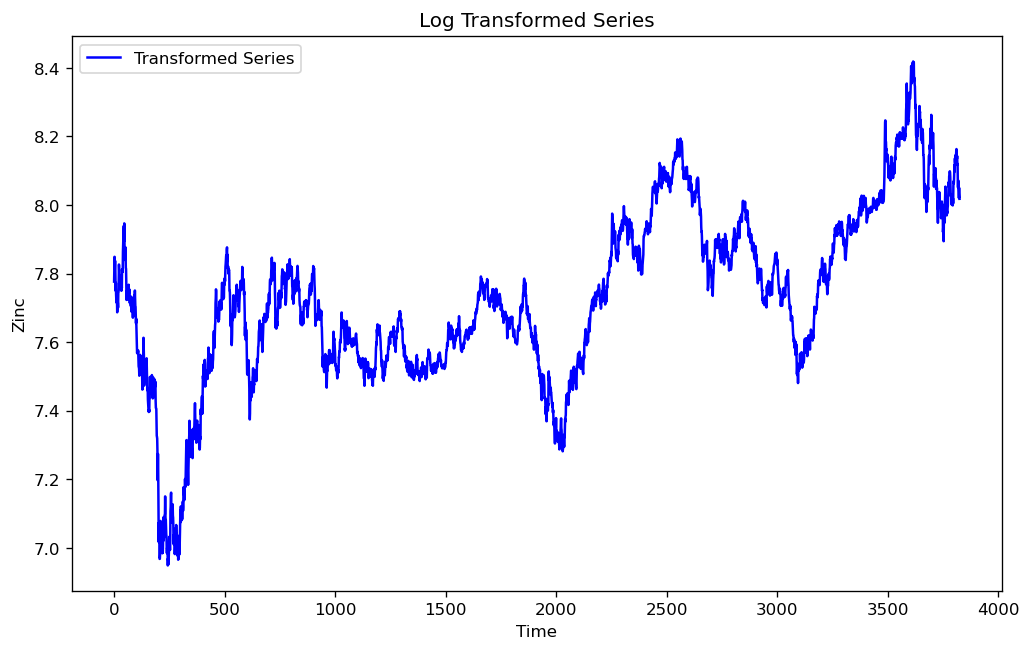

In [120]:

# Calculate the log of the adjusted close prices
df_zinc_log = np.log(df['Zinc'])


# Plot the transformed series
plt.figure(figsize=(10, 6))
plt.plot(df_zinc_log, color='blue', label='Transformed Series')
plt.xlabel('Time')
plt.ylabel('Zinc')
plt.title('Log Transformed Series')
plt.legend()
plt.show()

In order to make the time series stationary, we take the logarithm of the zinc prices.

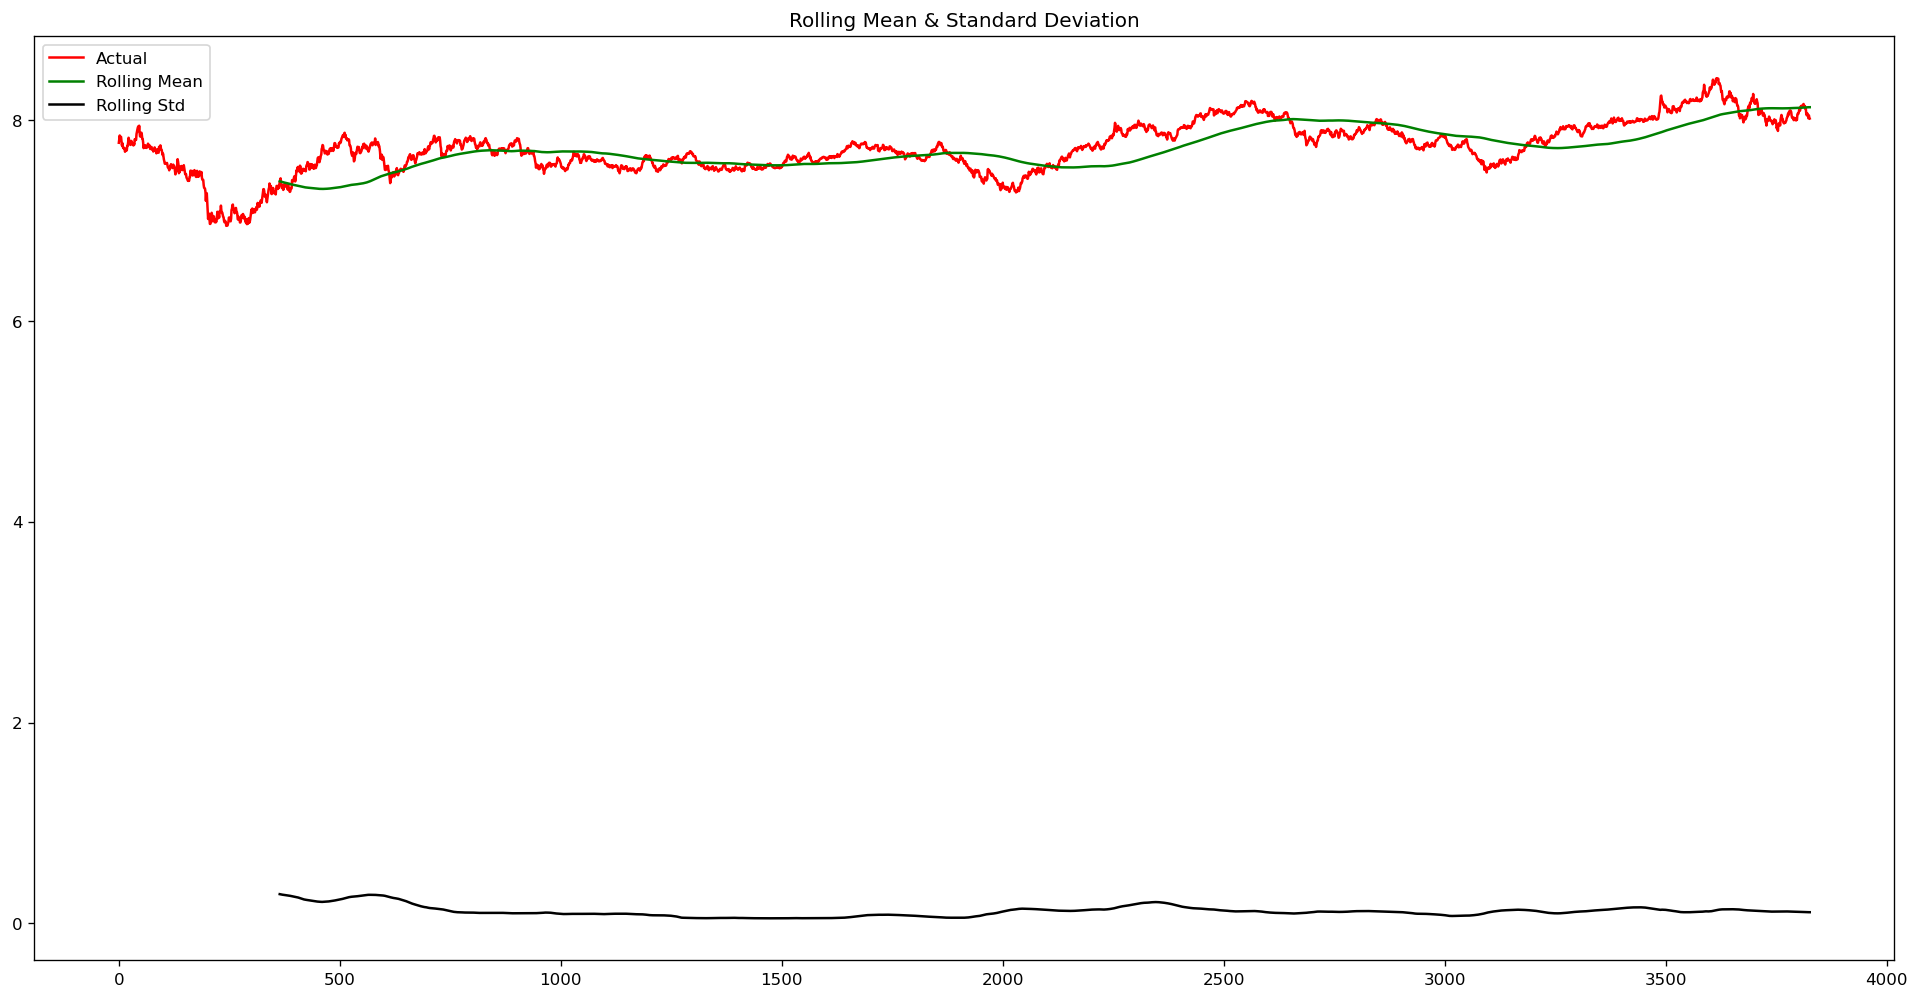

Dickey-Fuller Test: 
Test Statistic            -2.082008
p-value                    0.251810
Lags Used                  0.000000
No. of Obs              3826.000000
Critical Value (1%)       -3.432060
Critical Value (5%)       -2.862296
Critical Value (10%)      -2.567172
dtype: float64


In [121]:
df_log = pd.DataFrame()
df_log["Zinc"] = df_zinc_log

stationarity(df_log, 'Zinc')

The time series transformed into the logarithm scale is tested for stationarity. When the rolling mean and standard deviation is plotted against the actual values, though we observe a less fluctiating behaviour, the rolling mean and standard deviation still change with time. Looking at the results of the Augmented Dickey-Fuller test, we observe that the p-value is 0.251810, which is still higher than the desired value of 0.05. Based on these values, we can conclude that the time series is again non-stationary.

In [122]:
MAvg=df_log.rolling(window=12).mean()
MStd=df_log.rolling(window=12).std()

df_log_diff=df_log-MAvg

df_log_diff=df_log_diff.dropna()

Since the time series is still non-stationary, we need to differentiate it for a second time. First, we calculate the moving average and the moving standard variation of the log-scaled time series, then we subtract the moving average values from the series. 

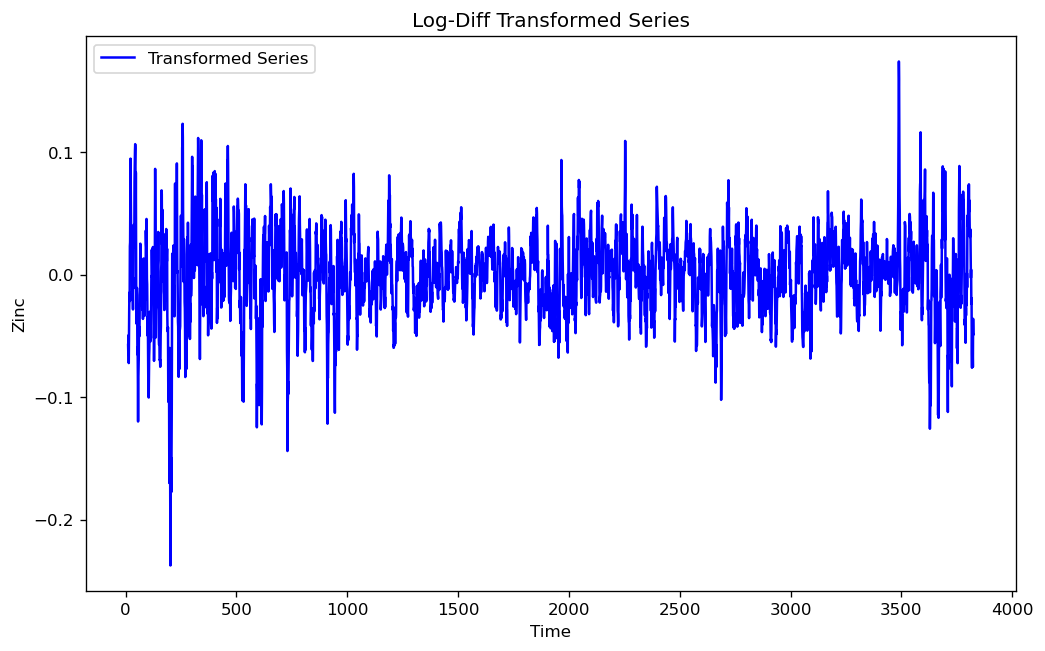

In [123]:
# Plot the transformed series
plt.figure(figsize=(10, 6))
plt.plot(df_log_diff, color='blue', label='Transformed Series')
plt.xlabel('Time')
plt.ylabel('Zinc')
plt.title('Log-Diff Transformed Series')
plt.legend()
plt.show()

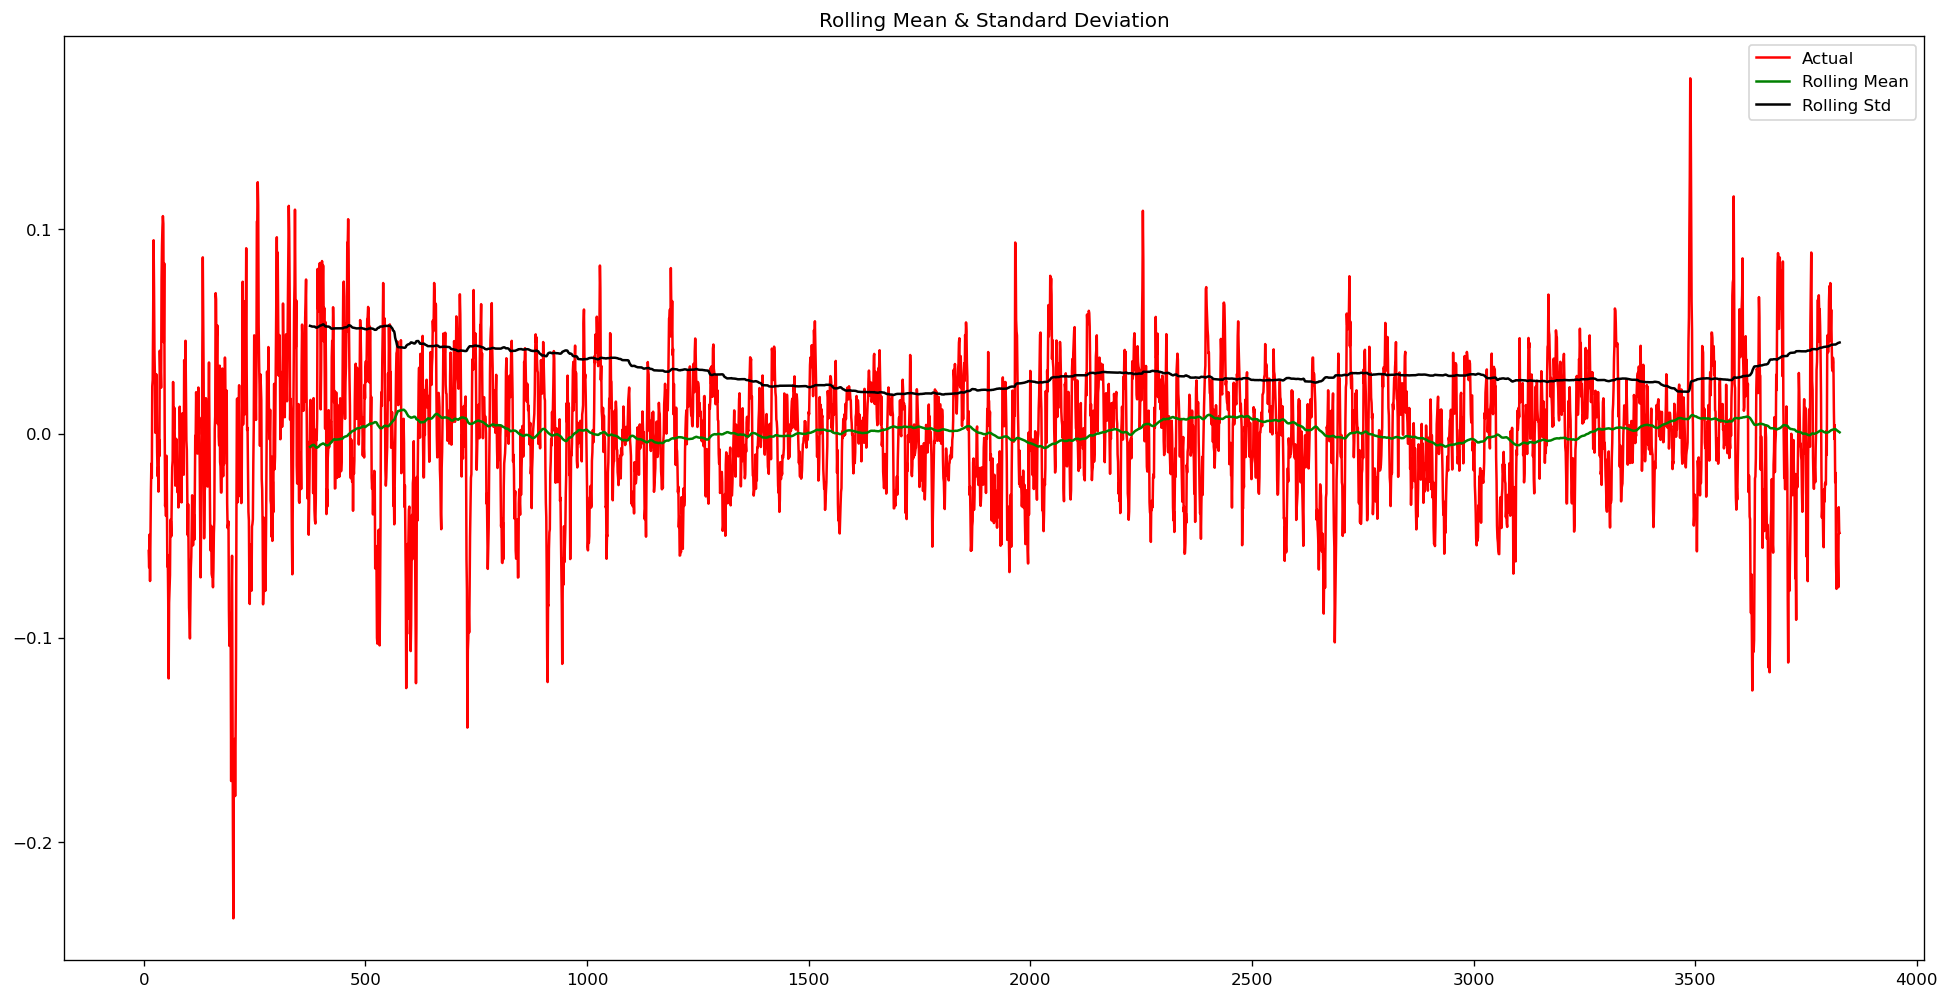

Dickey-Fuller Test: 
Test Statistic         -1.433175e+01
p-value                 1.096896e-26
Lags Used               1.300000e+01
No. of Obs              3.802000e+03
Critical Value (1%)    -3.432071e+00
Critical Value (5%)    -2.862300e+00
Critical Value (10%)   -2.567175e+00
dtype: float64


In [124]:
stationarity(df_log_diff,'Zinc') 

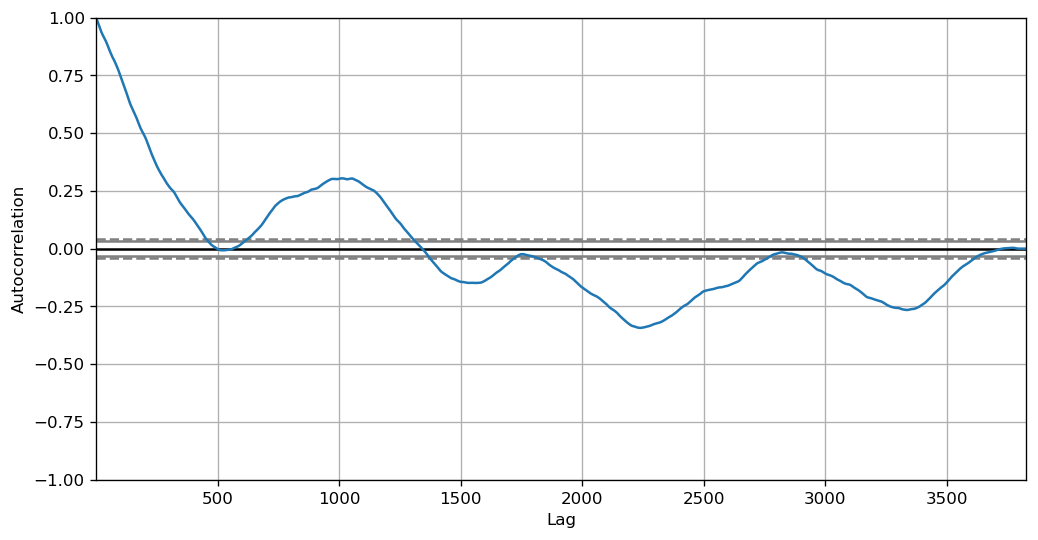

In [125]:
# Test for seasonality
from pandas.plotting import autocorrelation_plot

# Draw Plot
plt.rcParams.update({'figure.figsize':(10,5), 'figure.dpi':120})
autocorrelation_plot(df['Zinc'].tolist())
plt.show()


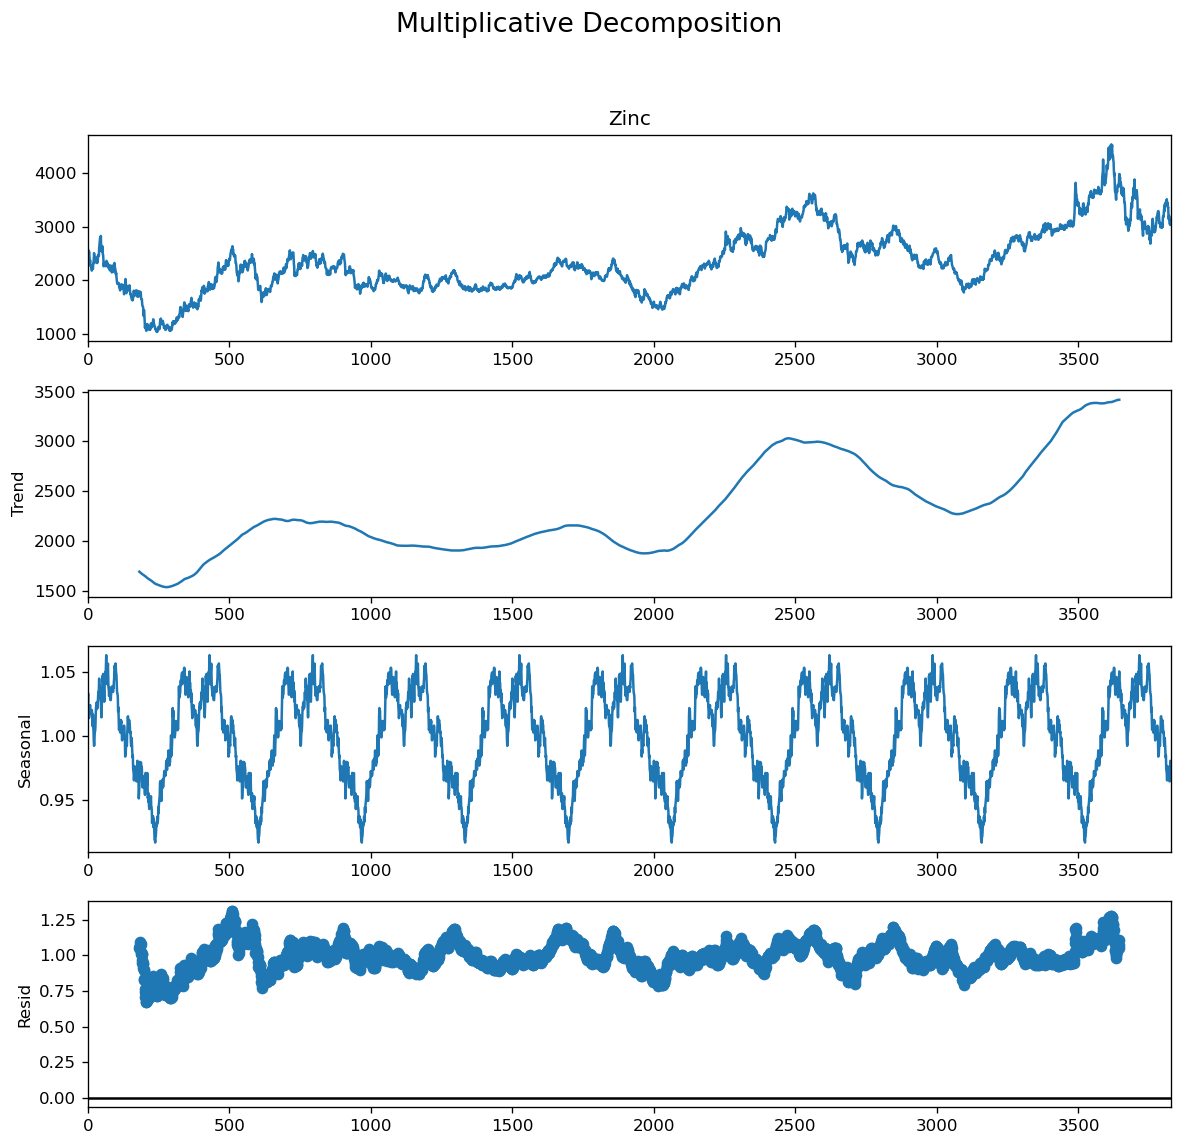

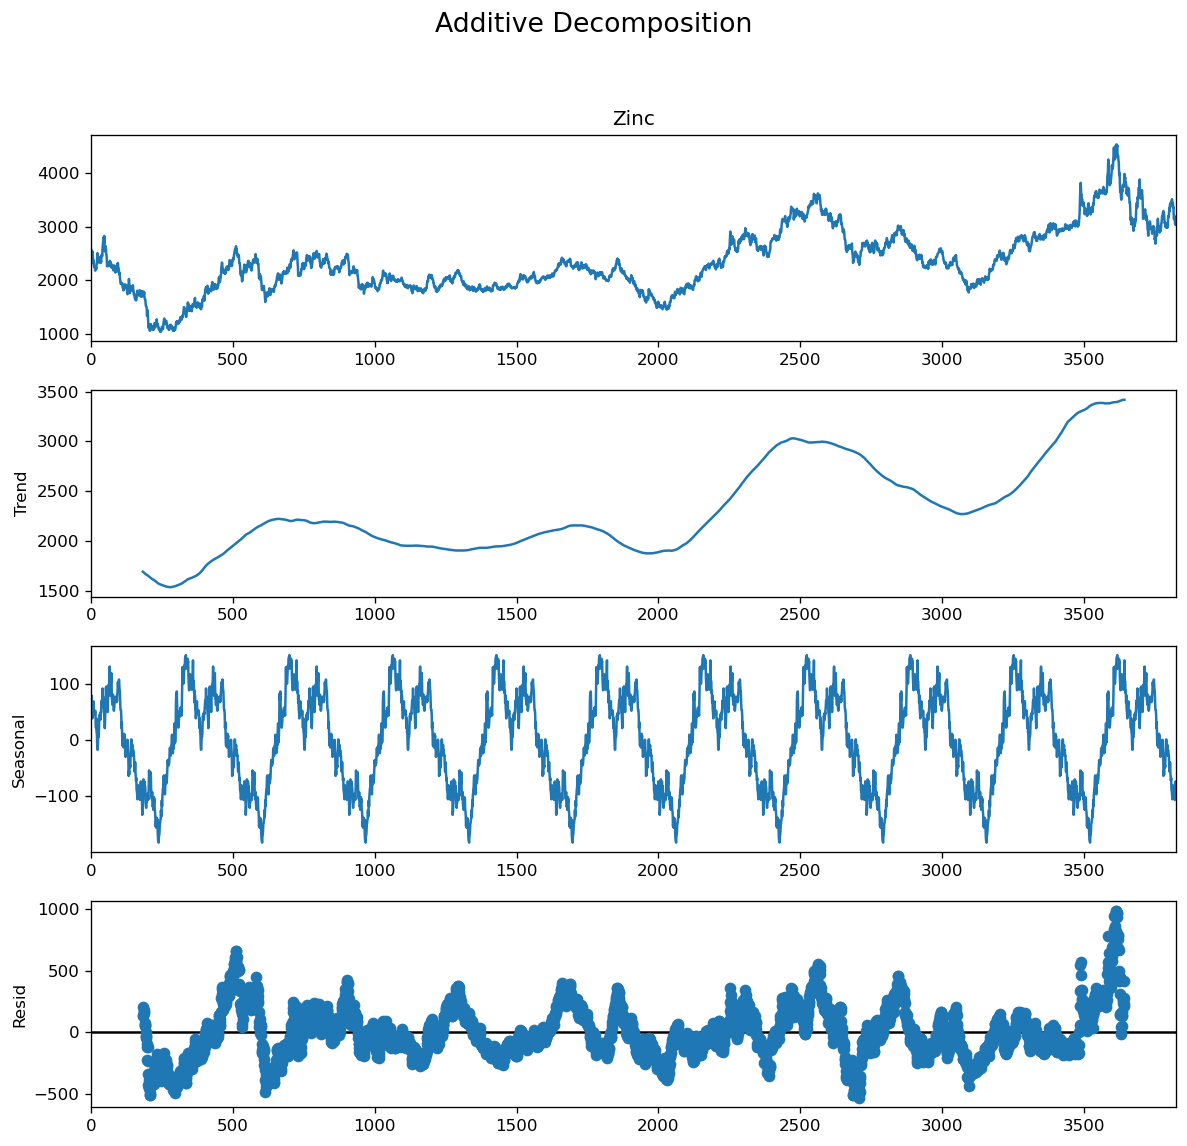

In [126]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Multiplicative Decomposition 
multiplicative_decomposition = seasonal_decompose(df['Zinc'], model='multiplicative', period=365)

# Additive Decomposition
additive_decomposition = seasonal_decompose(df['Zinc'], model='additive', period=365)

# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
multiplicative_decomposition.plot().suptitle('Multiplicative Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

additive_decomposition.plot().suptitle('Additive Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])


plt.show()

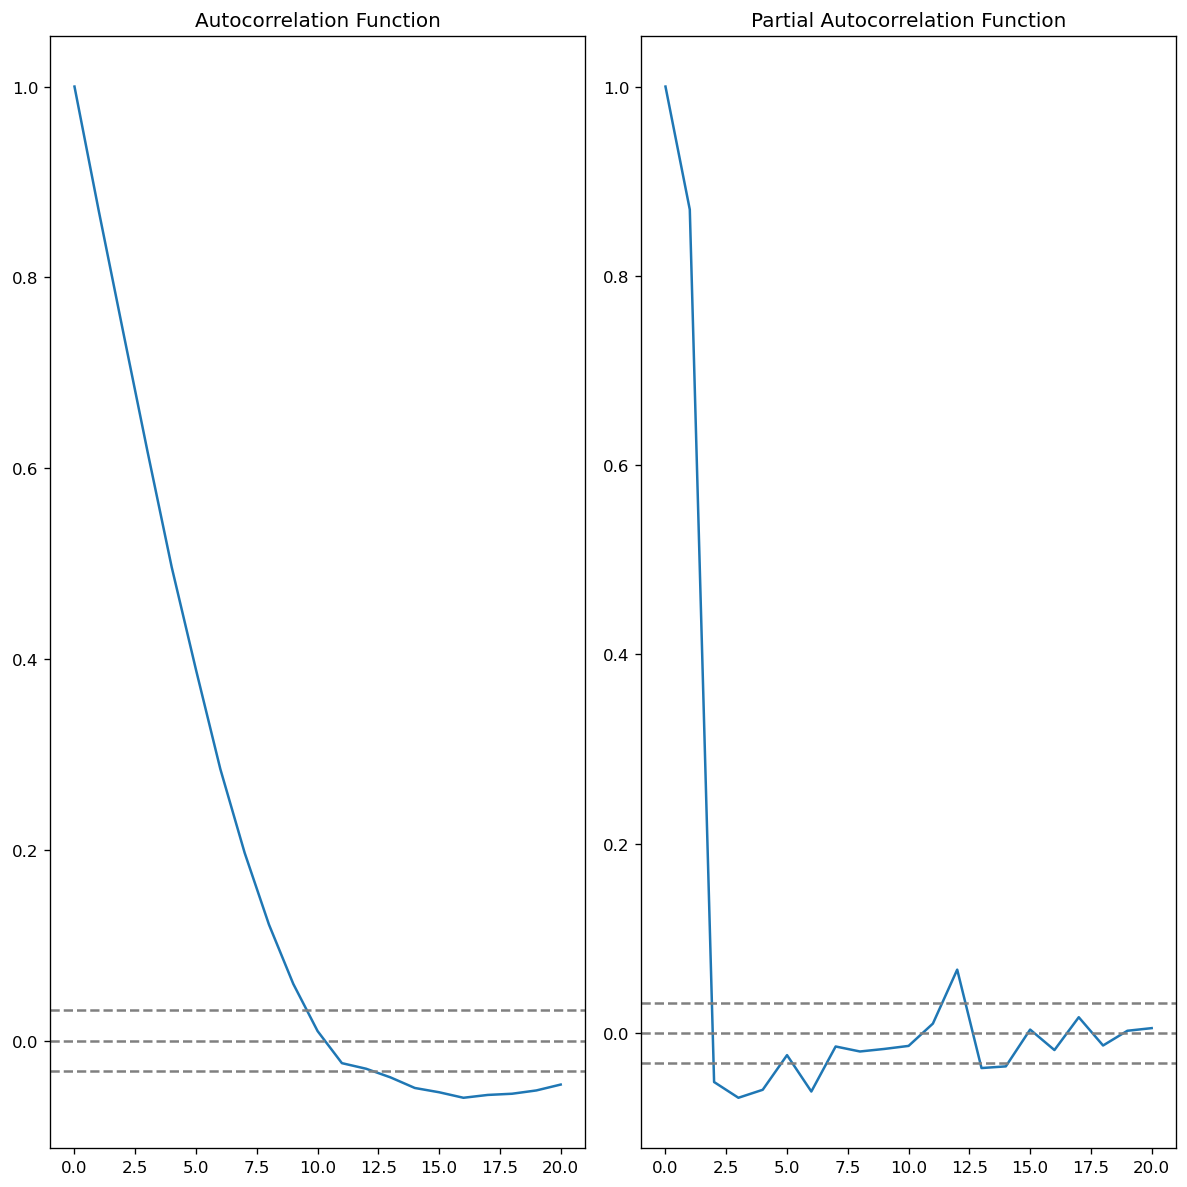

In [127]:
#ACF & PACF plots
lag_acf = acf(df_log_diff, nlags=20)
lag_pacf = pacf(df_log_diff, nlags=20, method='ols')
#Plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(df_log_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(df_log_diff)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')            
#Plot PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(df_log_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(df_log_diff)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')
            
plt.tight_layout()
plt.show()

d:\Anaconda\Anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


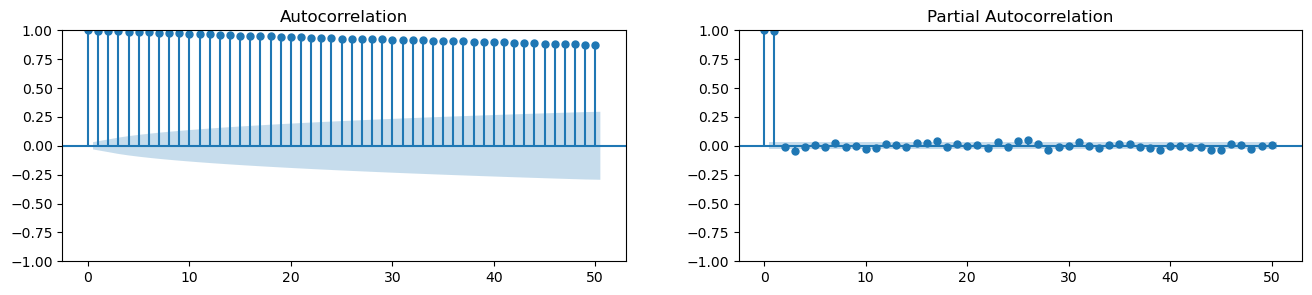

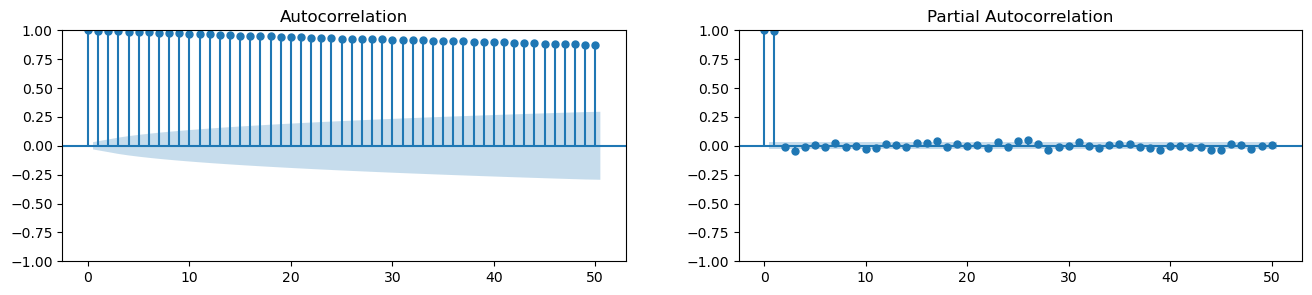

In [128]:
# Draw Plot
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(df['Zinc'].tolist(), lags=50, ax=axes[0])
plot_pacf(df['Zinc'].tolist(), lags=50, ax=axes[1])

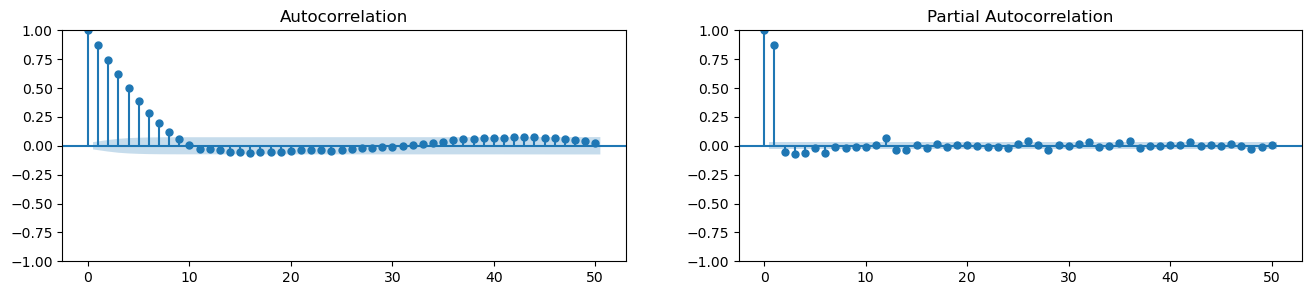

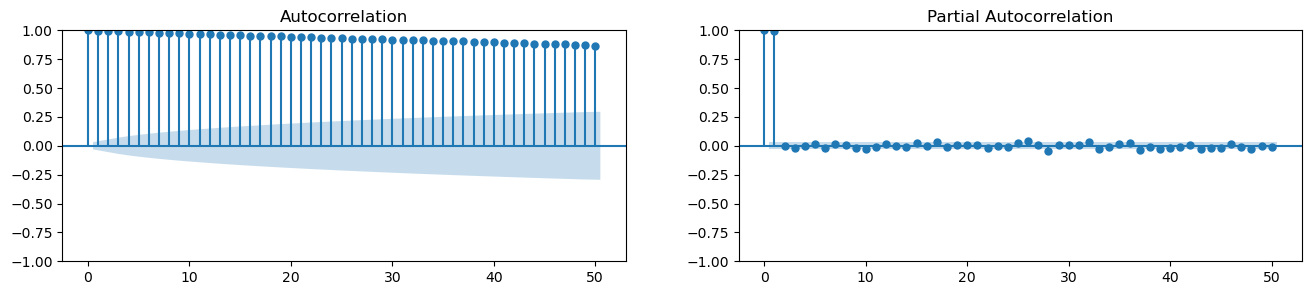

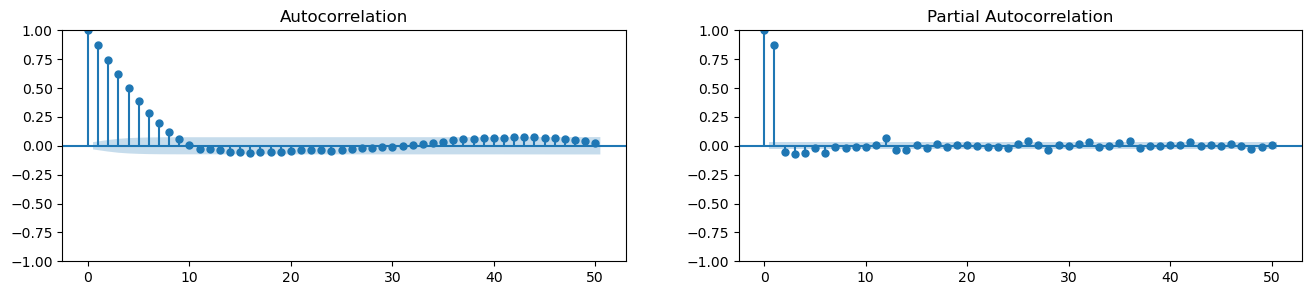

In [129]:
# Draw Plot
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(df_log['Zinc'].tolist(), lags=50, ax=axes[0])
plot_pacf(df_log['Zinc'].tolist(), lags=50, ax=axes[1])

# Draw Plot
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(df_log_diff['Zinc'].tolist(), lags=50, ax=axes[0])
plot_pacf(df_log_diff['Zinc'].tolist(), lags=50, ax=axes[1])